In [1]:
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata

def get_lon_lat(fhead):
    #fhead = 'data/50SMG20164100'
    # generate a list of the forth and fifth letter
    a = map(chr, range(65, 91))
    a.remove('I')
    a.remove('O')
    
    #get the corner coordinates for each tile
    # the mgrs gives the lower left coordinate

    t = fhead.split('201')[0][-5:]
    bl = t
    ul = t.replace(t[-1], a[a.index(t[-1])+1])
    br = t.replace(t[-2], a[a.index(t[-2])+1])
    ur = t.replace(t[-2], a[a.index(t[-2])+1]).replace(t[-1], a[a.index(t[-1])+1])
    
    m = mgrs.MGRS()
    b_l = list(m.toLatLon(bl))
    u_l = list(m.toLatLon(ul))
    b_r = list(m.toLatLon(br))
    u_r = list(m.toLatLon(ur))
    
    return np.array([u_l, u_r, b_l, b_r])

def transform():
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    tx = osr.CoordinateTransformation(wgs84, modis_sinu )
    
    return tx

def get_mextend():
    tx = transform()
    
    m_lon1, modis_lat, modis_z = tx.TransformPoint (180, 0)
    m_lon0, modis_lat, modis_z = tx.TransformPoint (-180, 0)
    modis_lon, m_lat0, modis_z = tx.TransformPoint (0, 90)
    modis_lon, m_lat1, modis_z = tx.TransformPoint (0, -90)
    
    return (m_lon0, m_lon1, m_lat0, m_lat1)

def get_steps():
    m_lon0, m_lon1, m_lat0,m_lat1 = get_mextend()
    
    lon_step = (m_lon1-m_lon0)/36.
    lat_step = (m_lat0-m_lat1)/18.
    lon_cstep = lon_step/2400.
    lat_cstep = lon_step/2400.
    
    return (lon_step, lat_step, lon_cstep, lat_cstep)


def get_coords(m_lon, m_lat):
    
    #tx = transform()
    
    #m_lon, m_lat, m_z = tx.TransformPoint(lon, lat)
    
    lon_step, lat_step, lon_cstep, lat_cstep = get_steps()
    
    m_lon0, m_lon1, m_lat0, m_lat1 = get_mextend()
    
    v = ((m_lat0 - m_lat)/lon_step).astype('int')
    h = ((m_lon - m_lon0)/lat_step).astype('int')
    
    p_x = np.ceil((m_lat0 - m_lat)/lat_cstep) - (v)*2400 
    p_y = np.ceil((m_lon - m_lon0)/lon_cstep) - (h)*2400
    
    return p_x.astype('int'), p_y.astype('int')

def interp(m_lats, m_lons):
    
    x = [0, 0, 10980, 10980]
    y = [0,10980, 0, 10980]
    corinds = np.array([x,y]).T
    
    grid_x, grid_y = np.mgrid[0:10980, 0:10980]
    
    Alats = griddata(corinds, m_lats, (grid_x, grid_y), method='linear')
    Alons = griddata(corinds, m_lons, (grid_x, grid_y), method='linear')
    
    return (Alats, Alons)

def get_inds(fhead):
    
    tx = transform()
    cors = get_lon_lat(fhead)
    #indexes = []
    #for i in cors:
     #   indexes.append(get_coords(cors[1], cors[0]))
    
    cor_lats = cors[:,0]; cor_lons = cors[:,1]
    cds = zip(cor_lons,cor_lats)
    
    mc = tx.TransformPoints(cds)
    
    m_lats = np.array([i[0] for i in mc])
    m_lons = np.array([i[1] for i in mc])
    
    m_lats, m_lons = interp(m_lats, m_lons)
    x_inds, y_inds = get_coords(m_lons, m_lats)
    
    return x_inds, y_inds

In [7]:
fname = '50SMG20164100'
Alats, Alons = get_inds(fname)

In [10]:
import sys
sys.path.insert(0,'python')
from dimg import *
from readSent import *
from fast_rw import *
%matplotlib inline

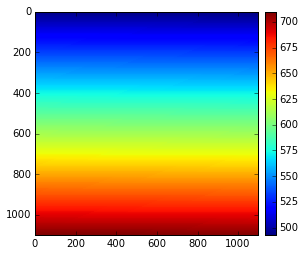

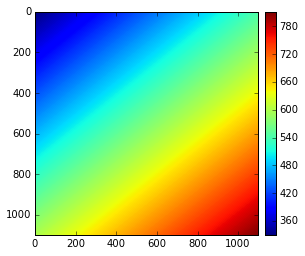

In [14]:
dimg(Alats, step=10)
dimg(Alons, step=10)

In [16]:
import glob
import gdal
glob.glob('m_data/MCD43A*.A2016105.h27v05.005.*.hdf')

['m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf',
 'm_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf',
 'm_data/MCD43A3.A2016105.h27v05.005.2016122100739.hdf']

In [17]:
modis_filenames = gdal.Open('m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf').GetSubDatasets()
modis_filenames

[('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band1',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band1 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band2',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band2 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band3',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band3 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band4',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band4 MOD_Grid_BRDF (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A1.A2016105.h27v05.005.2016122100738.hdf":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band5',
  '[2400x2400x3] BRDF_Albedo_Parameters_Band5 MOD_Grid_BRDF (16-bit integer

In [18]:
modisQA = gdal.Open("m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf").GetSubDatasets()
modisQA

[('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Quality',
  '[2400x2400] BRDF_Albedo_Quality MOD_Grid_BRDF (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:Snow_BRDF_Albedo',
  '[2400x2400] Snow_BRDF_Albedo MOD_Grid_BRDF (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Ancillary',
  '[2400x2400] BRDF_Albedo_Ancillary MOD_Grid_BRDF (16-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"m_data/MCD43A2.A2016105.h27v05.005.2016122100739.hdf":MOD_Grid_BRDF:BRDF_Albedo_Band_Quality',
  '[2400x2400] BRDF_Albedo_Band_Quality MOD_Grid_BRDF (32-bit unsigned integer)')]

In [19]:
def r_modis(fname):
    g = gdal.Open(fname)
    if g is None:
        raise IOError
    else:
        return g.ReadAsArray()

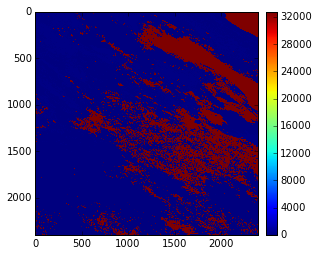

In [29]:
b1_brdf = r_modis(modis_filenames[0][0])
dimg(b1_brdf[0])

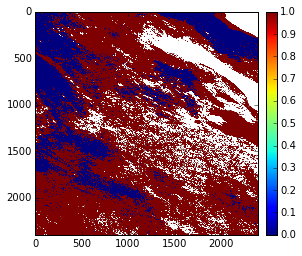

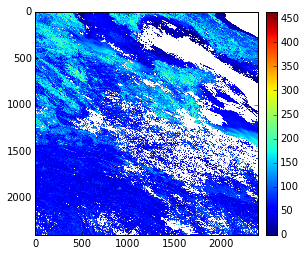

In [30]:
import numpy.ma as ma
QA = r_modis(modisQA[0][0])
dimg(ma.array(QA, mask=QA>1))

brdf_m = (b1_brdf[0] > 32766) | (b1_brdf[1] > 32766) |(b1_brdf[2] > 32766)
dimg(ma.array(b1_brdf[0], mask = (QA>1)|brdf_m))

In [44]:
tile_brdf = ma.array([ma.array(b1_brdf[i], mask = (QA>1)|brdf_m)[Alats,Alons] for i in range(3)])

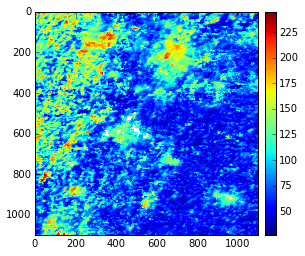

In [46]:
dimg(tile_brdf[0], step=10)

In [47]:
# read in the corresponding band
co_bands = readfile([4,], 'data/50SMG20164100', bounds =None)

data/50SMG20164100auxiliaryECMWFT
data/50SMG20164100metadata.xml


In [52]:
print co_bands.keys()

['TCO3', 'VIAG_Z', 'MSLP', 'mSz', 'SAG_Z', 'mVz', 'TCWV', 'mVa', 'SAG_A', 'B04', 'VIAG_A', 'mSa']


In [72]:
b4 = co_bands['B04']
sza = co_bands['mSz'][0]
vza = co_bands['mVz'][3]
rel_a = (co_bands['mSa']-co_bands['mVa'])[3]
sza, vza, rel_a

(33.149554848796299, 5.3685313495404499, 45.382839438459982)

In [73]:
import kernels
kk = kernels.Kernels(vza ,sza,rel_a,\
                     RossHS=False,MODISSPARSE=True,\
                     RecipFlag=True,normalise=1,\
                     doIntegrals=False,LiType='Dense',RossType='Thick')

In [77]:
k_vol = kk.Ross
k_geo   = kk.Li
iso =  kk.Isotropic
#k_vol = ScaleExtent(ross); k_geo = ScaleExtent(li)

In [83]:
k_vol, k_geo

(masked_array(data = -0.0158036328152,
              mask = False,
        fill_value = 0.0), masked_array(data = -0.764675248497,
              mask = False,
        fill_value = 0.0))

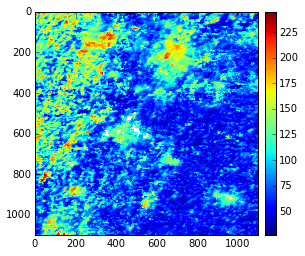

In [88]:
dimg(tile_brdf[0], step=10)

In [78]:
R = tile_brdf[0] + tile_brdf[1]*k_vol + tile_brdf[2]*k_geo

In [89]:
import cPickle as pkl
vm = pkl.load(open('pkls/vm.pkl'))

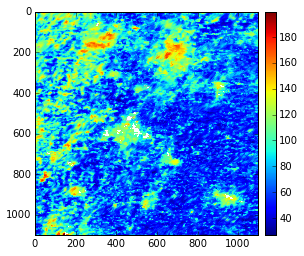

In [92]:
dimg(R,step=10)

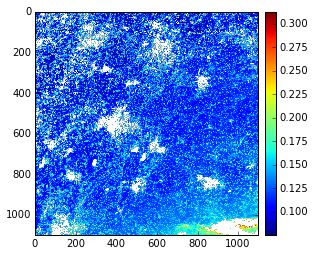

In [90]:
dimg(ma.array(b4, mask=~vm),step=10)

In [93]:
mask = R.mask|~vm

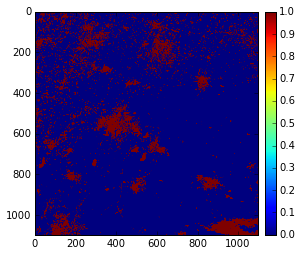

In [94]:
dimg(mask,step=10)

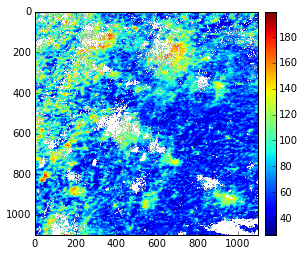

In [95]:
dimg(ma.array(R.data, mask=mask),step=10)

In [99]:
R.shape, b4.shape

((10980, 10980), (10980, 10980))

In [112]:
dis = 680
b4cut = b4[:-dis, :-dis]
brdfcut = (R.data)[dis:,dis:]
vmcut = vm[:-dis, :-dis]
bmcut = (R.mask)[dis:,dis:]
vmcut.shape, bmcut.shape

((10300, 10300), (10300, 10300))

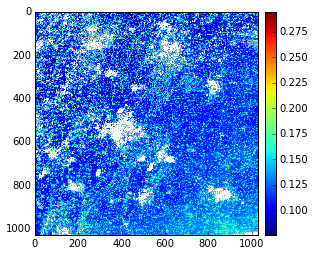

In [115]:
dimg(ma.array(b4cut, mask = bmcut|~vmcut),step=10)

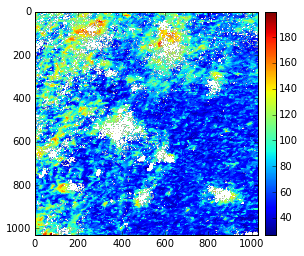

In [113]:
dimg(ma.array(brdfcut, mask= bmcut|~vmcut),step=10)

In [116]:
from smoothn import *

In [166]:
def smooth(data):
    print data
    return smoothn(data, isrobust=True)

In [164]:
b4cut

array([[ 0.0987,  0.0975,  0.0996, ...,  0.1045,  0.1127,  0.1134],
       [ 0.0989,  0.0961,  0.0989, ...,  0.1047,  0.112 ,  0.1226],
       [ 0.096 ,  0.099 ,  0.1014, ...,  0.1065,  0.117 ,  0.1355],
       ..., 
       [ 0.1188,  0.1356,  0.1601, ...,  0.3271,  0.3245,  0.3271],
       [ 0.1275,  0.1447,  0.1675, ...,  0.3299,  0.3202,  0.3185],
       [ 0.1238,  0.1408,  0.1678, ...,  0.3377,  0.334 ,  0.3355]])

In [177]:
import multiprocessing
from functools import partial
par = partial(smoothn, isrobust = True)
pool = multiprocessing.Pool(processes = 16)
a = pool.map(par, (b4cut, brdfcut))
pool.close()
pool.join()

MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.


In [118]:
sbrdf = smoothn(brdfcut, isrobust=True)
sb4 = smoothn(b4cut, isrobust = True)

MATLAB:smoothn:SLowerBound
s = 0.029 : the lower bound for s has been reached. Put s as an input variable if required.


python/smoothn.py:256: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Lambda = Lambda + (cos(pi*(arange(1,sizy[i]+1) - 1.)/sizy[i]).reshape(siz0))


In [175]:
b4cut

array([[ 0.0987,  0.0975,  0.0996, ...,  0.1045,  0.1127,  0.1134],
       [ 0.0989,  0.0961,  0.0989, ...,  0.1047,  0.112 ,  0.1226],
       [ 0.096 ,  0.099 ,  0.1014, ...,  0.1065,  0.117 ,  0.1355],
       ..., 
       [ 0.1188,  0.1356,  0.1601, ...,  0.3271,  0.3245,  0.3271],
       [ 0.1275,  0.1447,  0.1675, ...,  0.3299,  0.3202,  0.3185],
       [ 0.1238,  0.1408,  0.1678, ...,  0.3377,  0.334 ,  0.3355]])

In [125]:
sbrdf[0]*0.001

array([[ 0.11747221,  0.11747221,  0.11747221, ...,  0.08902165,
         0.08902149,  0.08902139],
       [ 0.11747221,  0.11747221,  0.11747221, ...,  0.08679873,
         0.08679869,  0.08679864],
       [ 0.11747221,  0.11747221,  0.11747221, ...,  0.08342745,
         0.08342795,  0.08342817],
       ..., 
       [ 0.09302922,  0.09302922,  0.09302922, ...,  0.054     ,
         0.054     ,  0.054     ],
       [ 0.0925468 ,  0.0925468 ,  0.0925468 , ...,  0.054     ,
         0.054     ,  0.054     ],
       [ 0.09248348,  0.09248348,  0.09248348, ...,  0.054     ,
         0.054     ,  0.054     ]])

In [139]:
mask = (sbrdf[0]*0.001>0.4)|(sbrdf[0]*0.001<0)

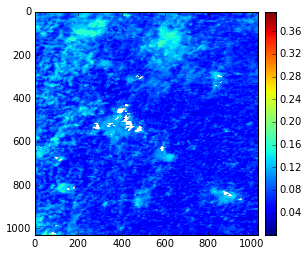

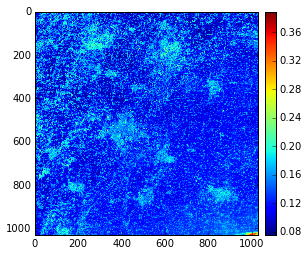

In [154]:
dimg(ma.array(sbrdf[0]*0.001, mask = mask),step=10)
dimg(sb4[0],step=10)

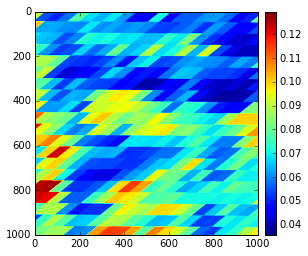

In [152]:
dimg(ma.array(sbrdf[0]*0.001, mask = mask)[5000:6000, 5000:6000])

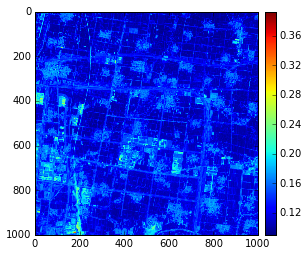

In [153]:
dimg(sb4[0][5000:6000,5000:6000])

In [141]:
w_p = np.where(~mask)
a = np.arange(len(w_p[0]))
px = []
py = []
for i in range(100000):
    ind = np.random.choice(a)
    py.append(w_p[1][ind])

In [144]:
randsb4 = sb4[0][px,py]
randsbrdf = sbrdf[0][px,py]*0.001

In [146]:
randsb4,randsbrdf

(array([ 0.1566321 ,  0.14519759,  0.10133604, ...,  0.1491369 ,
         0.1587209 ,  0.17275476]),
 array([ 0.05146766,  0.06199999,  0.05549285, ...,  0.08893014,
         0.056     ,  0.12727288]))

In [148]:
np.polyfit(randsbrdf,randsb4, 1)

array([ 0.17083198,  0.11900344])

In [178]:
parallel_rw_pkl(sbrdf, 'sbrdf', o = 'w')
parallel_rw_pkl(sb4, 'sb4', o = 'w')

In [ ]:
Nbig = 10980
Nsmall = 183

small1 = b3_brdf.reshape([Nsmall, Nbig/Nsmall, Nsmall, Nbig/Nsmall]).mean(3).mean(1)